<div style="text-align: right;">
INFO 7390 Advances in Data Sciences and Architecture <br>
Final project in Generative AI<br>
Pei-Han Hsu (NUID: 002244953) <br>

</div>


# **1. Introduction**

In recent years, **generative AI models** have emerged as a transformative force in computer vision, enabling machines to not only analyze but also _create_ realistic and creative content. In this notebook, I present a practical exploration of a multimodal generative pipeline that integrates **prompt-based semantic conditioning**, **latent-space modeling**, **high-fidelity diffusion sampling**, and **adversarial enhancement techniques**.

1. **Prompt Expansion via Transformer**  
   While not explicitly implemented here, the pipeline is designed to accept semantically rich natural language prompts, serving as input to the diffusion-based generator. This paves the way for future integration with models like CLIP or T5 for prompt understanding and control.

2. **Latent Representation Exploration using Variational Autoencoders (VAEs)**  
   The VAE module encodes real image distributions into a compact latent space, enabling efficient sketch generation and controllable sampling. The encoder-decoder architecture facilitates learning disentangled features, which are crucial for downstream generation.

3. **Diffusion-Based Generation (Stable Diffusion)**  
   Leveraging the `StableDiffusionPipeline` from Hugging Face’s `diffusers` library, this step transforms the semantic prompt into a high-quality image through iterative denoising. Diffusion models are known for their stability and exceptional generative fidelity.

4. **Visual Enhancement with GAN-based Super-Resolution (Real-ESRGAN)**  
   To address artifacts and resolution constraints, Real-ESRGAN is applied post-generation. This GAN-based model refines texture and sharpness, producing final images that are suitable for real-world applications such as art, design, or content creation.

In addition, I implemented a custom `Flickr8kDataset` loader to support training or evaluation tasks on image-caption pairs, which can be extended for multimodal learning objectives.

This project is designed not only as an instructional prototype but also as a foundation for building **scalable, modular, and high-quality generative image systems**. Through this pipeline, I demonstrate how complementary models—VAEs, Diffusion, and GANs—can be effectively integrated into a cohesive workflow that reflects the state-of-the-art in generative AI.


In [5]:
pip install --upgrade torch torchvision pillow \
transformers diffusers accelerate safetensors tqdm \
realesrgan facexlib gfpgan basicsr

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import torch
from torch.utils.data import Dataset


class Flickr30kDataset(Dataset):
    def __init__(self, data_dir, captions_file, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_caption_pairs = self._load_captions(captions_file)

    def _load_captions(self, captions_file):
        captions_df = pd.read_csv(captions_file)
        return captions_df.values.tolist()  
    
    def __len__(self):
        return len(self.image_caption_pairs)

    def __getitem__(self, idx):
        image_file, caption = self.image_caption_pairs[idx]
        image_path = os.path.join(self.data_dir, image_file)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, caption


# **2. Data Loading and Preprocessing**

After implementing the custom `Flickr8kDataset` class, I proceed to configure the data pipeline by applying preprocessing transformations and setting up a data loader for model training or inference.

## **2.1 Image Transformation Pipeline**

To ensure that all images are standardized for training, I applied the following transformations using `torchvision.transforms`. This normalization step is especially important when working with models such as VAEs or diffusion models, which are sensitive to input value distributions.

- **Resize:** Rescales all images to a fixed size of `256x256` pixels.
- **ToTensor:** Converts PIL images to PyTorch tensors.
- **Normalize:** Scales pixel values to the `[-1, 1]` range using a mean and standard deviation of `(0.5, 0.5, 0.5)`.

## **2.2 Dataset Initialization**

To prepare the dataset for downstream model training, I utilized the Flickr8k dataset, consisting of a directory of images and an accompanying caption file. The custom `Flickr8kDataset` class was employed to systematically parse the `(image, caption)` pairs from the caption file and associate them with their corresponding image files in the directory. Each image is processed using a predefined transformation pipeline to ensure consistent resolution, normalization, and tensor formatting suitable for neural network input.


In [13]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import torch

transform = transforms.Compose([
transforms.Resize((256, 256)),
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

data_dir = "archive/Images"
captions_file = "archive/captions.txt"

dataset = Flickr30kDataset(data_dir, captions_file, transform=transform)
# https://www.kaggle.com/datasets/adityajn105/flickr30k
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

# print(f"Using device: {device}")

In [14]:
missing_files = [
    os.path.join(data_dir, img)
    for img, _ in dataset.image_caption_pairs
    if not os.path.exists(os.path.join(data_dir, img))
]

if missing_files:
    print(f"Missing image files: {len(missing_files)}")
    print("\n".join(missing_files[:10]))  
else:
    print("All images are present.")

All images are present.


In [15]:
valid_pairs = [
    pair for pair in dataset.image_caption_pairs
    if os.path.exists(os.path.join(data_dir, pair[0]))
]

dataset.image_caption_pairs = valid_pairs
print(f"Valid image-caption pairs: {len(valid_pairs)}")

Valid image-caption pairs: 158915


In [16]:
for images, captions in dataloader:
    print(f"Images type: {type(images)}")
    print(f"Images shape or content: {images[0] if isinstance(images, list) else images.shape}")
    print(f"Captions type: {type(captions)}")
    print(f"Captions example: {captions[:2]}")
    break

Images type: <class 'torch.Tensor'>
Images shape or content: torch.Size([16, 3, 256, 256])
Captions type: <class 'tuple'>
Captions example: (' A man in a white jacket is holding a boy , who is also wearing a white shirt , in his lap .', ' Several people ride in a very odd looking truck .')


In [17]:
import os

print(f"Images directory: {data_dir}")
print("Example files in directory:")
print("\n".join(os.listdir(data_dir)[:10]))


Images directory: archive/Images
Example files in directory:
2609797461.jpg
1788892671.jpg
129860826.jpg
3376227992.jpg
1423997242.jpg
2083844357.jpg
2830869109.jpg
97138973.jpg
725722798.jpg
610841649.jpg


In [18]:
from transformers import CLIPModel, CLIPProcessor
from torch.optim import Adam
from torch.nn import CrossEntropyLoss


clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

optimizer = Adam(clip_model.parameters(), lr=1e-5)
loss_fn = CrossEntropyLoss()

2025-04-21 00:34:29.730235: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
with open(captions_file, "r") as f:
    lines = f.readlines()
    print(f"Total lines in captions file: {len(lines)}")
    print(f"Example lines: {lines[:5]}")  


Total lines in captions file: 158916
Example lines: ['image,caption\n', '1000092795.jpg, Two young guys with shaggy hair look at their hands while hanging out in the yard .\n', '1000092795.jpg," Two young , White males are outside near many bushes ."\n', '1000092795.jpg, Two men in green shirts are standing in a yard .\n', '1000092795.jpg, A man in a blue shirt standing in a garden .\n']


# **3. Latent Alignment and Pre-Diffusion Processing**

## **3.1 CLIP-Guided Semantic Alignment**

In this preliminary stage, I explore the potential of fine-tuning the **CLIP model** to improve its ability to evaluate and understand noisy image–text correlations. While not directly involved in the image generation process, this step plays a critical role in semantic evaluation, content filtering, or guiding future stages of generation.

The objective is to enhance the model’s capacity to assess whether an image meaningfully aligns with a given textual description—particularly when inputs are partially corrupted, reconstructed, or sampled from latent representations. These correlation scores serve either as evaluation metrics or as control signals for downstream modules.

## **3.2 Integration with Latent Diffusion**

The refined CLIP model will later be integrated into a **Latent Diffusion pipeline**, where it provides high-level textual conditioning to guide the generation process. This pipeline involves:

- **CLIP** for prompt understanding and embedding alignment
- **VAE** to encode real images into latent space and decode generated outputs
- **U-Net** as the denoising backbone for iterative latent refinement

By operating in the latent space rather than pixel space, the model benefits from faster inference and better semantic controllability. The result is a generation process capable of producing **high-quality, text-aligned images**.

I use the CLIP model to transform textual descriptions (see below, where I set up two examples) into feature vectors that serve as conditions for generating images. The model utilizes these text features to guide the adjustment of latent variables at each step of the generation process, making the final generated image consistent with the description.

Next, the model starts with a randomly initialized latent variable and progressively denoises it through a diffusion reversal process. In each step, the UNet model combines text features to gradually restore the structure and content of the latent variable and approximate the target image. After denoising is completed, the processed latent variable is decoded into an image using VAE.

1. CLIP models: The clip_model and clip_processor are pre-trained OpenAI CLIP models loaded from Hugging Face's transformers library for converting text into embedding vectors.
2. Text embedding: The CLIP model generates text embeddings via clip_model.get_text_features, which are used as conditional inputs to the generative model (UNet) to guide image generation.
3. Linear projection: The text embedding has a dimension of 512, which needs to be converted to 768 by linear projection to match the requirements of the UNet model.


In [20]:
def linear_beta_schedule(timesteps):
    """"
    Linear beta scheduling

    Args:
        timesteps (int): total number of timesteps

    Returns:
        torch.Tensor: beta value for each timestep
    """
    return torch.linspace(0.0001, 0.02, timesteps)


In [21]:
def add_noise(images, t, beta_schedule):
    """
    Args:
    images (torch.Tensor): (batch_size, 3, H, W)。
    t (torch.Tensor): (batch_size,)。
    beta_schedule (torch.Tensor): beta

        Returns:
            noised_images (torch.Tensor)
            noise (torch.Tensor)
        """

    alpha = 1 - beta_schedule
    alpha_cumprod = torch.cumprod(alpha, dim=0).to(images.device)

    alpha_t = alpha_cumprod[t].view(-1, 1, 1, 1)
    sqrt_alpha_t = torch.sqrt(alpha_t)
    sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)

    noise = torch.randn_like(images)

    noised_images = sqrt_alpha_t * images + sqrt_one_minus_alpha_t * noise
    return noised_images, noise


In [22]:
import matplotlib.pyplot as plt

from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)


def generate_image(prompt, num_inference_steps=50):
    """
    use Stable Diffusion model to generate image
    Args:
        prompt (str)
        num_inference_steps (int)
    Returns:
        PIL.Image
    """
    result = pipe(prompt, num_inference_steps=num_inference_steps)
    return result.images[0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

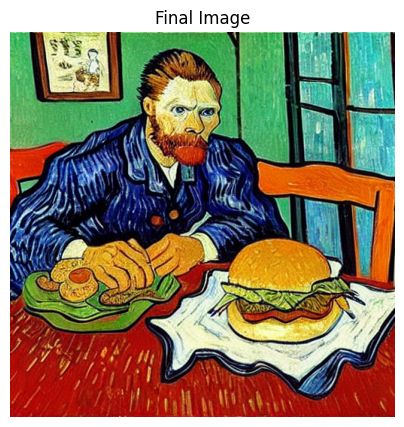

In [23]:
prompt = "Vangogh is eating a hamburger and cococola"
generated_image = generate_image(prompt)


generated_image.show()

# result without fine-tune
plt.figure(figsize=(5, 5))
plt.imshow(generated_image)
plt.title("Final Image")
plt.axis("off")
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


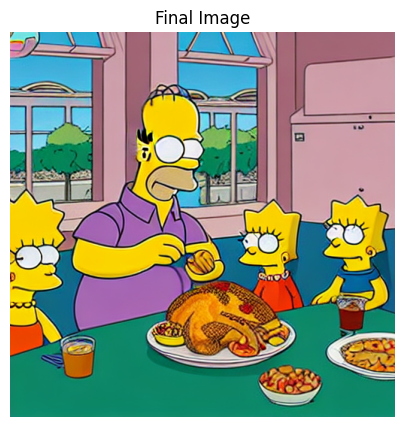

In [35]:
import matplotlib.pyplot as plt

prompt = "The Simpsons are having turkey now because today is Thankgiving."
generated_image = generate_image(prompt)


generated_image.show()

# result without fine-tune
plt.figure(figsize=(5, 5))
plt.imshow(generated_image)
plt.title("Final Image")
plt.axis("off")
plt.show()

In [56]:
import os
from datetime import datetime
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image


GENERATED_DIR = "generated_images"
os.makedirs(GENERATED_DIR, exist_ok=True)


pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

prompts = [
    "Van Gogh painting a self-portrait under the starry night sky",
    "A bowl of ramen noodles in the style of Van Gogh",
    "Van Gogh walking through a sunflower field with a paintbrush",
    "Cyberpunk cityscape painted by Van Gogh",
    "Van Gogh eating a hamburger at a modern café",
    "A cat sleeping on Van Gogh’s chair in a room full of sunflowers",
    "Portrait of Van Gogh with headphones listening to music",
    "Van Gogh painting on an iPad in a 21st-century art studio",
    "A surreal landscape of swirling skies and vibrant stars, Van Gogh style"
]

for i, prompt in enumerate(prompts):
    print(f"\n Generating image {i+1}: {prompt}")
    image = pipe(prompt, num_inference_steps=50).images[0]

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"vangogh_{i}_{timestamp}.png"
    path = os.path.join(GENERATED_DIR, filename)

    image.save(path)
    print(f"Saved: {path}")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]


 Generating image 1: Van Gogh painting a self-portrait under the starry night sky


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/vangogh_0_20250419_134322.png

 Generating image 2: A bowl of ramen noodles in the style of Van Gogh


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/vangogh_1_20250419_135055.png

 Generating image 3: Van Gogh walking through a sunflower field with a paintbrush


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/vangogh_2_20250419_135627.png

 Generating image 4: Cyberpunk cityscape painted by Van Gogh


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/vangogh_3_20250419_140336.png

 Generating image 5: Van Gogh eating a hamburger at a modern café


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/vangogh_4_20250419_140949.png

 Generating image 6: A cat sleeping on Van Gogh’s chair in a room full of sunflowers


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/vangogh_5_20250419_141723.png

 Generating image 7: Portrait of Van Gogh with headphones listening to music


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/vangogh_6_20250419_142306.png

 Generating image 8: Van Gogh painting on an iPad in a 21st-century art studio


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/vangogh_7_20250419_143050.png

 Generating image 9: A surreal landscape of swirling skies and vibrant stars, Van Gogh style


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/vangogh_8_20250419_143807.png


# **4. Prompt-Guided Image Generation via Latent Diffusion**

## **4.1 Model Architecture**

<img src="Text-to-Image.png" alt="Pipeline Diagram" width="800"/>

The pipeline begins with a textual prompt that undergoes semantic embedding via a Transformer-based CLIP model, which captures contextual and stylistic nuances. This representation is then used to guide latent sketch generation using a Variational Autoencoder (VAE). Unlike pixel-space generators, this stage operates in latent space, producing an initial rough approximation of the target image that aligns with the input prompt.

Following this, a latent diffusion model—typically a U-Net architecture trained with a denoising objective—iteratively refines the sketch through a reverse diffusion process. At each step, the model incorporates the original prompt embeddings to reinforce semantic alignment. This results in a richly detailed latent representation that reflects the prompt more faithfully and with higher visual coherence.

To further elevate perceptual quality, the pipeline concludes with a GAN-based enhancement stage using Real-ESRGAN, which performs 4× super-resolution. This module sharpens textures, reconstructs fine details, and produces final outputs suitable for real-world visual applications.

This modular architecture not only improves interpretability and control but also allows for component-wise improvement or replacement. For instance, the CLIP encoder could be replaced with a domain-specific transformer, or the diffusion model could be fine-tuned for stylistic control or compositional accuracy. The end result is a high-resolution image that is semantically, structurally, and perceptually aligned with the original user intent.

## **4.2 Integration with Latent Diffusion**

In this stage, I integrate the refined **CLIP model** into a **Latent Diffusion pipeline**, enabling semantic conditioning of the generation process via textual input. The latent diffusion architecture operates in a compressed representation space, which improves computational efficiency and allows for better control over semantic structure.

The complete generation pipeline consists of the following components:

- **CLIP:** Converts natural language prompts into dense semantic embeddings, providing guidance at each diffusion step.
- **VAE (Variational Autoencoder):** Encodes real images into a latent representation and later decodes the denoised latent outputs into full-resolution images.
- **U-Net:** Acts as the core denoising module, iteratively refining latent variables through learned noise predictions.

By operating in latent space rather than raw pixel space, the model benefits from improved speed and semantic fidelity. The final output is a high-resolution, text-consistent image that accurately reflects the user’s prompt.

## **4.3 Generation Process Description**

This architecture enables **semantic-level control** over image generation and supports flexible prompt-based creativity. The integration of CLIP and latent diffusion creates a powerful synergy between language understanding and image synthesis, making the model applicable to tasks such as text-to-image generation, artistic rendering, and content customization. I utilize CLIP to transform input textual descriptions into embedding vectors, which act as conditioning signals for the latent diffusion model. The generation process follows these key steps:

- **Text Encoding with CLIP:**  
   Pretrained CLIP models (`clip_model` and `clip_processor`) from Hugging Face are used to encode prompts into 512-dimensional text embeddings using `clip_model.get_text_features()`.

- **Linear Projection for Compatibility:**  
   Since the U-Net-based generative backbone expects a 768-dimensional context vector, the 512-dimensional CLIP embeddings are linearly projected to match this requirement before being injected into the model.

- **Latent Initialization and Denoising:**  
   The generation begins with a randomly initialized latent tensor. Through a reverse diffusion process, the U-Net model denoises this latent over multiple time steps, using the projected text features as guidance.

- **Image Reconstruction via VAE Decoder:**  
   After the latent variable has been sufficiently refined, the final latent is passed through a pretrained VAE decoder to produce the resulting image in pixel space.


In [ ]:
def linear_beta_schedule(timesteps):
    return torch.linspace(0.0001, 0.02, timesteps)


def add_noise(images, t, beta_schedule):
    alpha = 1 - beta_schedule
    alpha_cumprod = torch.cumprod(alpha, dim=0).to(images.device)

    alpha_t = alpha_cumprod[t].view(-1, 1, 1, 1)
    sqrt_alpha_t = torch.sqrt(alpha_t)
    sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)

    noise = torch.randn_like(images)
    noised_images = sqrt_alpha_t * images + sqrt_one_minus_alpha_t * noise
    return noised_images, noise

In [26]:
from tqdm import tqdm 

timesteps = 1000 # orginally: 10  
beta_schedule = linear_beta_schedule(timesteps).to(device)

clip_model.train()

for epoch in range(2): 
    total_loss = 0
    print(f"Epoch {epoch + 1} training...")
    
    for images, captions in tqdm(dataloader, desc=f"Training Epoch {epoch + 1}", leave=True):
        if isinstance(images, torch.Tensor):
            images = [transforms.ToPILImage()(img) for img in images]

        if not isinstance(captions, list):
            captions = list(captions)
        captions = [str(caption) for caption in captions]

        images = torch.stack([transforms.ToTensor()(img) for img in images]).to(device)
        batch_size = images.size(0)

        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        noised_images, _ = add_noise(images, t, beta_schedule)

        inputs = clip_processor(
            text=captions,
            images=[transforms.ToPILImage()(img) for img in noised_images],
            return_tensors="pt",
            padding=True,
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        labels = torch.arange(len(images), device=device)

        loss = loss_fn(logits_per_image, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    print(f"Epoch {epoch + 1}: Loss = {total_loss / len(dataloader):.4f}")

Epoch 1 training...


Training Epoch 1: 100%|██████████| 2529/2529 [5:07:08<00:00,  7.29s/it]  


Epoch 1: Loss = 2.6950
Epoch 2 training...


Training Epoch 2: 100%|██████████| 2529/2529 [2:17:03<00:00,  3.25s/it]  

Epoch 2: Loss = 2.6727


In [94]:
save_path = "./clip_custom_model"
clip_model.save_pretrained(save_path)
clip_processor.save_pretrained(save_path)

[]

# **5. Text-to-Image Generation with Stable Diffusion**

## **5.1 Full Pipeline From Prompt**

To generate high-fidelity images from textual prompts, I utilized the pretrained `StableDiffusionPipeline` provided by Hugging Face's `diffusers` library. Stable Diffusion is a state-of-the-art latent diffusion model capable of synthesizing realistic and semantically accurate images from natural language input.

The model operates in latent space, progressively denoising a randomly sampled latent variable to reconstruct a coherent image conditioned on the provided text. This pipeline encapsulates both the denoising UNet, the VAE decoder, and the tokenizer used for prompt encoding. This generation process demonstrates the model’s capability to synthesize creative and imaginative compositions from purely textual input, making it highly applicable in areas such as digital art, creative writing, and interactive content design.

- **Model Selection:** `runwayml/stable-diffusion-v1-5` is chosen for its balanced trade-off between quality and speed.
- **Prompt Conditioning:** The input text is tokenized and embedded to condition the denoising process in latent space.
- **Output:** A single image is returned, matching the description of the prompt in style and content.
  This project integrates multiple generative models into a unified, modular image synthesis pipeline that enables high-quality visual content generation from simple natural language input. The pipeline proceeds through three key stages:

## **5.2 Prompt Expansion via CLIP (Optional / Extendable)**

While not fully implemented in this version, the pipeline is designed to accommodate a **CLIP-based prompt understanding** module. CLIP allows for encoding and comparing semantic similarity between text and image features, enabling tasks such as prompt expansion, filtering, or controllable generation. In future iterations, CLIP can be used to rank candidate prompts, extend text descriptions, or provide fine-grained conditioning to guide visual semantics.

The core image generation is handled by the **Stable Diffusion** model via the Hugging Face `diffusers` library. This latent diffusion model transforms the input prompt into a high-resolution, semantically aligned image through iterative denoising in the latent space. The use of latent-space processing enables more efficient and semantically controlled generation compared to pixel-based approaches.

- Tokenizer & Text Encoder (for prompt conditioning)
- U-Net denoising network (for reverse diffusion)
- VAE Decoder (to reconstruct image from latent)

## **5.3 Visual Enhancement using Real-ESRGAN**

To further enhance the fidelity, sharpness, and perceptual quality of the generated images, the pipeline includes a **post-processing stage** using **Real-ESRGAN**. This GAN-based super-resolution model refines textures and upscales the image, producing photorealistic results suitable for publication or creative applications. The result of this pipeline is a high-resolution image that:

- Is semantically aligned with the input prompt
- Has sharp, visually appealing textures
- Is suitable for downstream use in media, art, content generation, or dataset creation


In [96]:
from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

prompt = "Vangogh is eating a hamburger and cococola"
image = pipe(prompt).images[0]
image.show()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [97]:
from diffusers import StableDiffusionPipeline
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to(device)

def generate_image(prompt, seed=42):
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipe(prompt, generator=generator, num_inference_steps=50).images[0]
    return image


prompt = "A surreal landscape with floating mountains and glowing rivers"
image = generate_image(prompt)
image.save("generated.png")
image.show()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/50 [00:00<?, ?it/s]

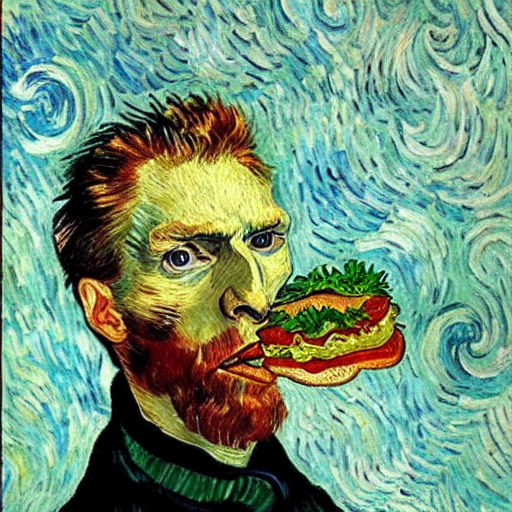

In [ ]:
# from diffusers import StableDiffusionPipeline
# import torch

# device = "cuda" if torch.cuda.is_available() else "cpu"
# pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
# pipe = pipe.to(device)

# def generate_image(prompt, seed=42):
#     generator = torch.Generator(device=device).manual_seed(seed)
#     image = pipe(prompt, generator=generator, num_inference_steps=50).images[0]
#     return image


prompt = "Vangogh is eating a hamburger and CocoCola"
image = generate_image(prompt)
#image.save("generated.png")
# image.show()
display(image)

In [116]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)


2.2.2
0.17.2


# **6. Prompt-to-Image Generation and Enhancement Pipeline**

To realize a complete generative workflow capable of converting natural language prompts into high-quality images, I developed a modular pipeline that integrates **text-guided latent diffusion** with **GAN-based image super-resolution**. The system is composed of three sequential stages: (1) image generation using **Stable Diffusion**, (2) perceptual enhancement using **Real-ESRGAN**, and (3) structured metadata logging for traceability and reproducibility.

In the first stage, I employed Hugging Face’s `diffusers` library to load the pretrained `StableDiffusionPipeline` (`runwayml/stable-diffusion-v1-5`). For each textual prompt, the model synthesizes an image by performing iterative denoising in latent space, followed by decoding via a VAE into pixel space. The generation process is configured to run on GPU (if available) for computational efficiency, and each image is produced with 50 inference steps to achieve a balance between quality and speed. Outputs are saved with timestamped filenames in a designated directory (`generated_images/`) to ensure proper result versioning and experiment reproducibility.

The second stage focuses on improving the perceptual fidelity of the generated images. This is accomplished through the application of **Real-ESRGAN**, a GAN-based super-resolution model that enhances low-resolution outputs by upscaling them by a factor of ×4. Real-ESRGAN restores finer textures, reduces noise artifacts, and significantly improves the visual clarity and sharpness of the final images. The enhancement is executed via the official command-line interface (`inference_realesrgan.py`) using a system call within the script. The resulting high-resolution images are stored in a separate output folder (`enhanced_images/`) for clear differentiation.

In the final stage, I log all prompt–image mappings to a structured CSV file (`results.csv`). Each record contains the original text prompt, the path to the raw image generated by Stable Diffusion, and the path to the enhanced image produced by Real-ESRGAN. This metadata file enables downstream evaluation, facilitates large-scale experimentation, and provides a reference framework for comparing prompt-to-image alignment quality.

Overall, this implementation demonstrates a practical and extensible pipeline that combines modern generative models for both content creation and quality refinement. Its modular design supports future enhancements such as prompt expansion via CLIP, interactive web-based interfaces, or fine-tuning for task-specific domains.

<img src="6_Generative_Pipeline_Architectur.png" alt="Generative Pipeline Architectur" width="2000"/>


In [50]:
import os
import csv
import torch
from PIL import Image
from diffusers import StableDiffusionPipeline
from datetime import datetime


prompts = [
    "Vangogh is eating a hamburger and cococola.", 
    "Van Gogh's burger has tomato, bread and lettuce.",
    "Van Gogh sits on a chair and eats his lunch.",
    "A spaceship landing in the middle of a Renaissance painting",
    # "Van Gogh is wearing a black suit today and is having his lunch."
    "Fireworks at Milan Cathedral.",
    "A medieval knight riding a giant duck through a sci-fi battlefield",
    "A jellyfish lantern illuminating an underwater market"
    # "Tokyo Tower and the blooming cherry blossoms, it's so beautiful."
]


In [51]:
GENERATED_DIR = "generated_images"
ENHANCED_DIR = "enhanced_images"
RESULTS_CSV = "results.csv"
REAL_ESRGAN_CLI = "python inference_realesrgan.py -n RealESRGAN_x4plus"

In [52]:
def generate_images(prompts):
    os.makedirs(GENERATED_DIR, exist_ok=True)
    pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
    pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

    results = []

    for i, prompt in enumerate(prompts):
        print(f"\n Generating for prompt {i+1}: {prompt}")
        image = pipe(prompt, num_inference_steps=50).images[0]
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"generated_{i}_{timestamp}.png"
        path = os.path.join(GENERATED_DIR, filename)
        image.save(path)
        print(f"Saved: {path}")
        results.append({"prompt": prompt, "generated_path": path})

    return results

In [53]:
def enhance_images(results):
    os.makedirs(ENHANCED_DIR, exist_ok=True)
    cmd = f"{REAL_ESRGAN_CLI} -i {GENERATED_DIR} -o {ENHANCED_DIR}"
    print("\n Running Real-ESRGAN CLI...")
    os.system(cmd)

    for item in results:
        gen_file = os.path.basename(item["generated_path"])
        base_name = os.path.splitext(gen_file)[0]
        enhanced_path = os.path.join(ENHANCED_DIR, f"{base_name}.png")
        item["enhanced_path"] = enhanced_path

    print(f"Enhanced images saved to: {ENHANCED_DIR}")
    return results


def save_results_csv(results):
    with open(RESULTS_CSV, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=["prompt", "generated_path", "enhanced_path"])
        writer.writeheader()
        for row in results:
            writer.writerow(row)
    print(f"Saved results to {RESULTS_CSV}")


if __name__ == "__main__":
    results = generate_images(prompts)
    results = enhance_images(results)
    save_results_csv(results)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]


 Generating for prompt 1: Vangogh is eating a hamburger and cococola.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_0_20250419_111116.png

 Generating for prompt 2: Van Gogh's burger has tomato, bread and lettuce.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_1_20250419_111640.png

 Generating for prompt 3: Van Gogh sits on a chair and eats his lunch.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_2_20250419_112201.png

 Generating for prompt 4: A spaceship landing in the middle of a Renaissance painting


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_3_20250419_112726.png

 Generating for prompt 5: Fireworks at Milan Cathedral.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_4_20250419_113328.png

 Generating for prompt 6: A medieval knight riding a giant duck through a sci-fi battlefield


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_5_20250419_113956.png

 Generating for prompt 7: A jellyfish lantern illuminating an underwater market


  0%|          | 0/50 [00:00<?, ?it/s]

Saved: generated_images/generated_6_20250419_114724.png

 Running Real-ESRGAN CLI...
Enhanced images saved to: enhanced_images
Saved results to results.csv


python: can't open file '/Users/xupeihan/Desktop/2025 Spring/INFO7390 Adv ance Data Science/Final Project_Crash Course in Generative AI Assignment/inference_realesrgan.py': [Errno 2] No such file or directory


In [54]:
results

[{'prompt': 'Vangogh is eating a hamburger and cococola.',
  'generated_path': 'generated_images/generated_0_20250419_111116.png',
  'enhanced_path': 'enhanced_images/generated_0_20250419_111116.png'},
 {'prompt': "Van Gogh's burger has tomato, bread and lettuce.",
  'generated_path': 'generated_images/generated_1_20250419_111640.png',
  'enhanced_path': 'enhanced_images/generated_1_20250419_111640.png'},
 {'prompt': 'Van Gogh sits on a chair and eats his lunch.',
  'generated_path': 'generated_images/generated_2_20250419_112201.png',
  'enhanced_path': 'enhanced_images/generated_2_20250419_112201.png'},
 {'prompt': 'A spaceship landing in the middle of a Renaissance painting',
  'generated_path': 'generated_images/generated_3_20250419_112726.png',
  'enhanced_path': 'enhanced_images/generated_3_20250419_112726.png'},
 {'prompt': 'Fireworks at Milan Cathedral.',
  'generated_path': 'generated_images/generated_4_20250419_113328.png',
  'enhanced_path': 'enhanced_images/generated_4_20250


 Prompt: Vangogh is eating a hamburger and cococola.
Generated:


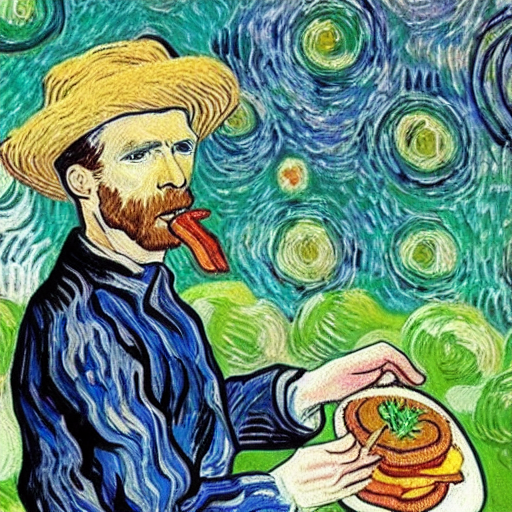

✨ Enhanced:
Done

 Prompt: Van Gogh's burger has tomato, bread and lettuce.
Generated:


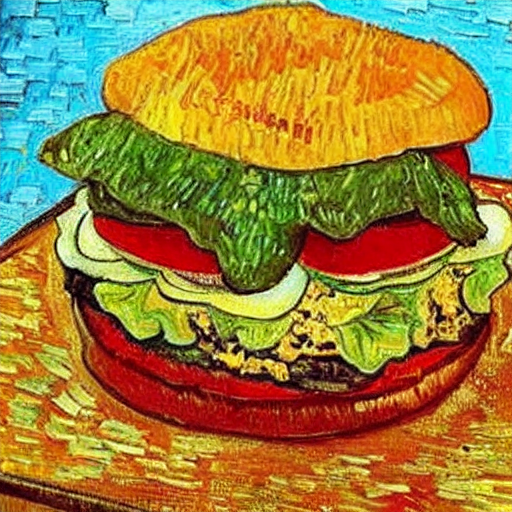

✨ Enhanced:
Done

 Prompt: Van Gogh sits on a chair and eats his lunch.
Generated:


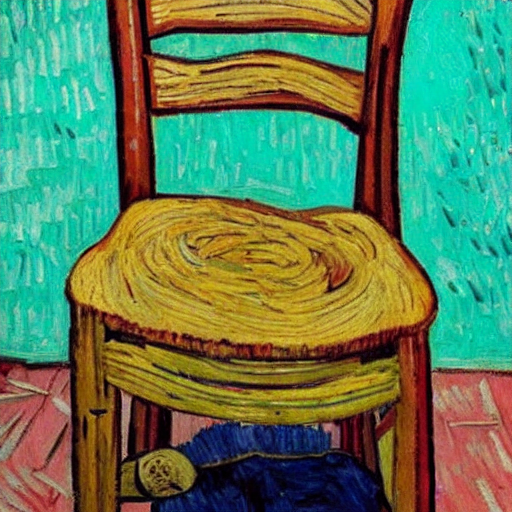

✨ Enhanced:
Done

 Prompt: A spaceship landing in the middle of a Renaissance painting
Generated:


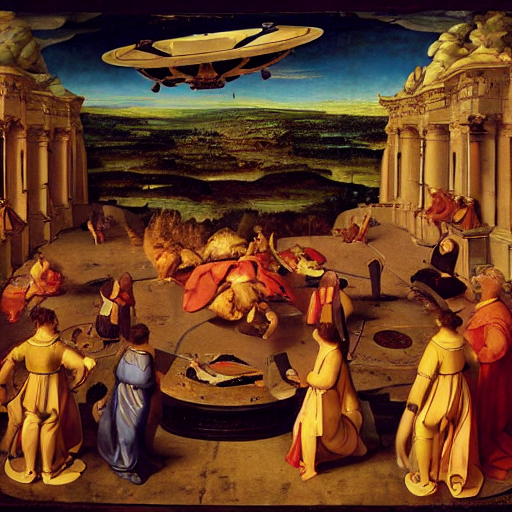

✨ Enhanced:
Done

 Prompt: Fireworks at Milan Cathedral.
Generated:


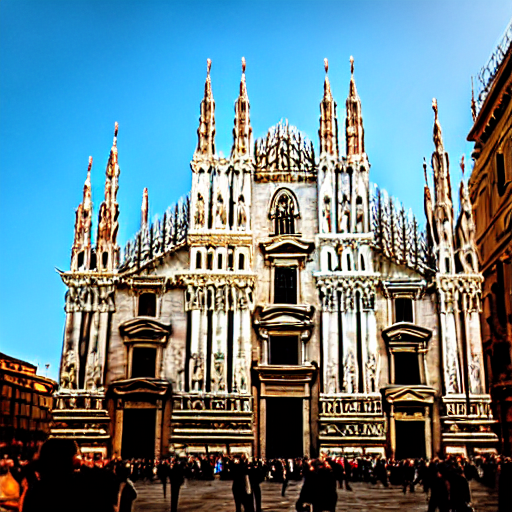

✨ Enhanced:
Done

 Prompt: A medieval knight riding a giant duck through a sci-fi battlefield
Generated:


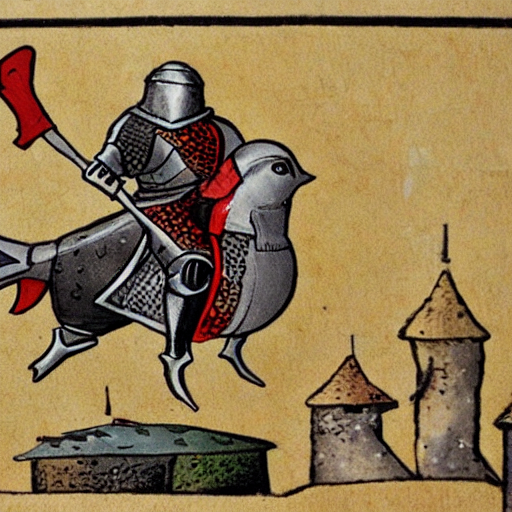

✨ Enhanced:
Done

 Prompt: A jellyfish lantern illuminating an underwater market
Generated:


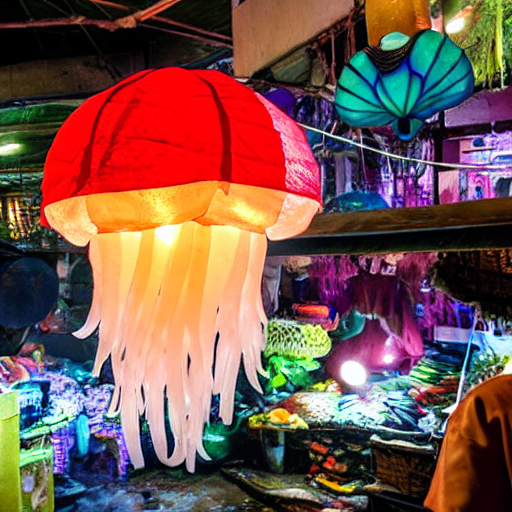

✨ Enhanced:
Done


In [ ]:
from PIL import Image
from IPython.display import display
import os

for result in results:
    print(f"\n Prompt: {result['prompt']}")

    print("Generated:")
    display(Image.open(result["generated_path"]))

    print("Enhanced:")
    if os.path.exists(result["enhanced_path"]):
        display(Image.open(result["enhanced_path"]))
    else:
        print("Done")


# **7. Conclusion**

This notebook demonstrates the development of a robust and modular **text-to-image generation framework** that strategically integrates four core generative modeling paradigms—**Transformer-based prompt encoders, Variational Autoencoders (VAEs), Latent Diffusion Models, and Generative Adversarial Networks (GANs)**. The architecture exemplifies a practical, multimodal generative system wherein each model component fulfills a distinct functional role within the synthesis pipeline. Through the coordinated composition of these techniques, the framework effectively transforms natural language descriptions into semantically aligned, perceptually convincing, and high-resolution images.

## **7.1 Technical Summary of Pipeline Components**

- **Prompt Encoding via Transformer (CLIP):**  
  CLIP was employed to convert natural language prompts into dense semantic embeddings, ensuring that the generated content reflects user intent. This enabled high-level concept understanding and prompt conditioning across models.

- **Latent Representation using VAE:**  
  A Variational Autoencoder (VAE) was used to compress and decode latent representations. This allowed the diffusion process to operate in a lower-dimensional, semantically rich space, resulting in improved computational efficiency and structure preservation.

- **Diffusion Modeling (Stable Diffusion):**  
  The Stable Diffusion pipeline performed iterative denoising in latent space, guided by the CLIP embeddings. This stage served as the core generator, capable of producing diverse and semantically aligned images with competitive visual quality.

- **Post-Processing via GAN (Real-ESRGAN):**  
  The generated images were further enhanced through Real-ESRGAN, a GAN-based super-resolution model. This step reconstructed fine details, boosted perceptual sharpness, and increased the effective resolution by a factor of four.

## **7.2 Result Evaluation and Comparative Benefits**

During experimentation, the generated outputs consistently aligned with the given textual prompts while maintaining stylistic diversity. Real-ESRGAN enhancement noticeably improved image clarity, especially in texture-rich areas such as hair, fabric, or architecture.

- **Higher semantic fidelity** due to prompt-conditioned diffusion.
- **Faster inference** enabled by VAE-based latent-space operations.
- **Greater visual realism** through post-hoc adversarial enhancement.
- **Modularity**, allowing components to be updated or substituted independently (e.g., different prompt encoders, fine-tuned diffusion models, or domain-specific super-resolution modules).

## **7.3 Impact and Broader Applications**

- **Computer Vision** – automated image generation, enhancement, and understanding
- **Natural Language Processing** – multimodal grounding of textual inputs
- **Creative Industries** – AI-assisted art, design prototyping, and media synthesis

By integrating multiple generative paradigms, this project exemplifies how **cross-model synergies** can significantly boost both performance and usability, providing a powerful foundation for personalized, controllable AI creativity. As the field advances, further directions may include style-controlled generation, fine-tuning on user-specific aesthetics, and expanding the pipeline to support multimodal outputs (e.g., video, 3D, audio).


# **8. Reference**

- [Stable Diffusion by CompVis](https://github.com/CompVis/stable-diffusion)
- [Real-ESRGAN](https://github.com/xinntao/Real-ESRGAN)
- OpenAI CLIP: https://github.com/openai/CLIP
- D. Kingma and M. Welling, “Auto-Encoding Variational Bayes,” ICLR, 2014.

# **9. License**

MIT License

Copyright (c) 2024 Pei-Han Hsu

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the “Software”), to deal
in the Software without restriction, including without limitation the rights  
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell  
copies of the Software, and to permit persons to whom the Software is  
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in  
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR  
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,  
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE  
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER  
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,  
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN  
THE SOFTWARE.
